In [1]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import time

start_date = '2020-03-01'
end_date ='2021-05-31'

a_qty = 20

a_fail_rate = .5

use_fail = False

unit_label = 'p/100m'

# survey data:
dfx= pd.read_csv('resources/checked_sdata_eos_2020_21.csv')


dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description

# code material map
code_m_map = dfCodes.material

def scaleTheColumn(x):
    
    xmin = x.min()
    xmax = x.max()
    xscaled = (x-xmin)/(xmax-xmin)
    
    return xscaled



# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

# All Data

This document details the methods used for the land use chapter of the IQAASL report. It has been expanded to include the supporting calculations for a manuscript based on the concepts intitially introduced in the report. Before consulting the results of all the data it may be interesting to understand how these figures relate when the same methods are applied at a smaller scale, such as a lake. See the previous two examples: Bielersee and Lac Léman.

The calculations are the same at each Geopraphic level. The number of samples and the mix of landuse attributes changes with every subset of data. It is those changes and how they relate to the magnitude of trash encountered that concerns these enquiries. This document assumes the reader knows what beach-litter monitoring is and how it applies to the health of the environment.

A statistical test is not a replacement for common sense. It is an another piece of evidence to consider along with the results from previous studies, the researchers personal experience as well as the history of the problem within the geographic constraints of the data.

## Notes

__excluded data__

At the time the report was published we did not have access to the land use data around Walensee. The good news is that it is now available with the most recent download. However, for this example the __data from Walensee is excluded__. This includes all samples that were taken in the region represented in the map below.

```{figure} resources/images/walensee_scaled.jpeg
---
name: 'walensee-map'
---
` `
```
{numref}`figure %s: <walensee-map>` Detail of the survey area for where there was no land use data.

__objects of interest__

The objects of interest are defined as __those objects where 20 or more were collected at one or more surveys__. In reference to the default data: that is the value of the quantity column:

In [2]:

pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series



new_label_keys = {
    1:"industrial",
    2:"buildings",
    3:"buildings",
    4:"buildings",
    5:"buildings",
    6:"transport",
    7:"transport",
    8:"transport",
    9:"buildings",
    10:"recreation",
    11:"agriculture",
    12:"agriculture",
    13:"agriculture",
    14:"agriculture",
    15:"agriculture",
    16:"agriculture",
    17:"woods",
    18:"agriculture",
    19:"woods",
    20:"woods",
    21:"woods",
    22:"woods",
    23:"water",
    24:"water",
    25:"unproductive",
    26:"unproductive",
    27:"unproductive"
}


def combineLandUseFeatures(buffer_data: pdtype = None, a_col: str = "AS18_27", new_col: str = "label",
                           new_label_keys: dict = new_label_keys) -> pdtype:
    """Assigns labels to landuse values according to <label_keys_new>. The new labels,
    when aggregated, create groups of landuse values that are similar. For exmaple,
    all the different types of buildings are labeled "buildings"
    
    Args:
        buffer_data: The land use values at a given radius
        a_col: The original column name that holds the labels for the land use values
        new_col: The new name of the column with the new labels
    
    Returns:
        The data frame with the new column and the new labels    
    """    
    
    buffer_data.rename(columns={"slug":"location", a_col:new_col}, inplace=True)
    buffer_data[new_col] = buffer_data[new_col].apply(lambda x : new_label_keys[x])
    
    return buffer_data

def adjustLandUse(buffer_data: pdtype = None, exclude_these: list = [], locations: list = []) -> pdtype:
    """The surface area of the water feature is removed from landuse calcluation. This
    can be bypassed. However, the study considers the surface area of the water as a fixed
    feature that exchanges with the different landuse features (which are not fixed).
    
    Args:
        buffer_data: The land use values at a given radius
        exclude_these: The labels to be excluded from the land use total
        locations: The locations of interest with buffer data
        
    Returns:
        The dataframe with the locations in locations and without the excluded labels      
    """
    data = buffer_data[~buffer_data.label.isin(exclude_these)]
    data = data[data.location.isin(locations)]
    
    return data

def addRoadLengthToBuffer(buffer_data: pdtype = None, location: str = None, 
                          road_lengths: pstype = None, scale: float = 1000.0):
    """Adds the length of road network to the % land use values.
    """
    
    road_length = road_lengths.loc[location]
    if scale != 1:
        road_length = round(road_length/scale, 1)
    
    buffer_data["roads"] = road_length
    
    return buffer_data

def addIntersectsToBuffer(buffer_data: pdtype = None, location: str = None, 
                          intersects: pstype = None, scale: float = 100.0):
    
    """Adds the number of river intersections to the buffer.
    
    The river intersections are the points where rivers join the body of water of interest
    """
    
    n_intersects = intersects.loc[location]
        
    buffer_data["intersects"] = n_intersects
    
    return buffer_data


def calculatePercentLandUse(buffer_data: pdtype = None, location: str = None, label: str = "label",
                           add_intersects_roads: bool = True,  road_lengths: pstype = None, intersects: pstype = None,) -> pd.Series:
    """Figures the % of total of each landuse feature for one location.
    
    Args:
        buffer_data: The land use values at a given radius
        location: The survey location of interest
    
    Returns:
        A pandas series of the % of total for each landuse feature in the index
    """
    
    try:
        # try to reitrieve the land use data for a location
        location_data = buffer_data[buffer_data.location == location][label].value_counts()
    except ValueError:
        print("The location data could not retrieved")
        raise
    
    # the sum of all land use features in the radius
    total = location_data.sum()
    # the amount of the area attributed to water (lakes and rivers)
    water = location_data.loc["water"]   
    # divide the land_use values by the total minus the amount attributed to water
    results = location_data/(total-water)
    # name the series
    results.name = location
    # the intersects and road-lengths are calculated seprately
    # if add_intersects and roads is true, attach them to the
    # the land use values
    if add_intersects_roads:
        results = addIntersectsToBuffer(buffer_data=results, location=location, intersects=intersects)
        results = addRoadLengthToBuffer(buffer_data=results, location=location, road_lengths=road_lengths)
        
    
    return results

class BufferData:
    a_col="AS18_27"
    new_col = "label"
    exclude_these = []
    label_keys = new_label_keys
    beach_data = dfBeaches
    
    
    
    def __init__(self, file_name: str = None, locations: list = []):
        self.buffer = pd.read_csv(file_name)
        self.buffer_data = combineLandUseFeatures(buffer_data=self.buffer, a_col=self.a_col, new_col=self.new_col)
        self.adjusted_buffer = adjustLandUse(buffer_data=self.buffer_data, exclude_these=self.exclude_these, locations=locations)
        self.pctLandUse = None
        self.locations = locations
        
    def percentLandUse(self):
        
        if isinstance(self.pctLandUse, pdtype):
            return self.pctLandUse
        
        if isinstance(self.adjusted_buffer, pdtype):
            results = []
            road_lengths = self.beach_data.streets
            intersects = self.beach_data.intersects
            for location in self.locations:
                result = calculatePercentLandUse(buffer_data=self.adjusted_buffer, location=location, road_lengths=road_lengths, intersects=intersects)
                results.append(result)
        else:
            raise TypeError
            
        self.pctLandUse = pd.concat(results, axis=1)
        
        return self.pctLandUse

def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Finished {} in {} secs".format(repr(func.__name__), round(run_time, 3)))
        return value

    return wrapper

def assignLanduseValue(sample: pstype=None, land_use: str=None) -> float:
    # returns the requested value of land use from the sample
    # if the requested landuse value is not present in the buffer
    # zero is returned
    try:
        result = sample.loc[land_use]
    except KeyError:
        result = 0
    
    return result

def cleanSurveyResults(data):
    # performs data cleaning operations on the
    # default data
    
    data['loc_date'] = list(zip(data.location, data["date"]))
    data['date'] = pd.to_datetime(data["date"])
    
    # get rid of microplastics
    mcr = data[data.groupname == "micro plastics (< 5mm)"].code.unique()
    
    # replace the bad code
    data.code = data.code.replace('G207', 'G208')
    data = data[~data.code.isin(mcr)]
    
    # walensee has no landuse values
    data = data[data.water_name_slug != 'walensee']   
    
    return data

class SurveyResults:
    """Creates a dataframe from a valid filename. Assigns the column names and defines a list of
    codes and locations that can be used in the CodeData class.
    """
    
    file_name = 'resources/checked_sdata_eos_2020_21.csv'
    columns_to_keep=[
        'loc_date',
        'location', 
        'river_bassin',
        'water_name_slug',
        'city',
        'w_t', 
        'intersects', 
        'code', 
        'pcs_m',
        'quantity'
    ]
        
    def __init__(self, data: str = file_name, clean_data: bool = True, columns: list = columns_to_keep, w_t: str = None):
        self.dfx = pd.read_csv(data)
        self.df_results = None
        self.locations = None
        self.valid_codes = None
        self.clean_data = clean_data
        self.columns = columns
        self.w_t = w_t
        
    def validCodes(self):
        # creates a list of unique code values for the data set    
        conditions = [
            isinstance(self.df_results, pdtype),
            "code" in self.df_results.columns
        ]

        if all(conditions):

            try:
                valid_codes = self.df_results.code.unique()
            except ValueError:
                print("There was an error retrieving the unique code names, self.df.code.unique() failed.")
                raise
            else:
                self.valid_codes = valid_codes
                
        
    def surveyResults(self):
        
        # if this method has been called already
        # return the result
        if self.df_results is not None:
            return self.df_results
        
        # for the default data self.clean data must be called        
        if self.clean_data is True:
            fd = cleanSurveyResults(self.dfx)
            
        # if the data is clean then if can be used directly
        else:
            fd = self.dfx
        
        # filter the data by the variable w_t
        if self.w_t is not None:
            fd = fd[fd.w_t == self.w_t]            
         
        # keep only the required columns
        if self.columns:
            fd = fd[self.columns]
        
        # assign the survey results to the class attribute
        self.df_results = fd
        
        # define the list of codes in this df
        self.validCodes()
        
        return self.df_results
    
    def surveyLocations(self):
        if self.locations is not None:
            return self.locations
        if self.df_results is not None:
            self.locations = self.dfResults.location.unique()
            return self.locations
        else:
            print("There is no survey data loaded")
            return None    


class CodeData:
    
    def __init__(self, data: pdtype = None, code: str = None, **kwargs):
                
        self.data = data
        self.code = code
        self.code_data = None       
    
    def makeCodeData(self)->pdtype:
        
        if isinstance(self.code_data, pdtype):
            return self.code_data        
        
        conditions = [
            isinstance(self.data, pdtype)            
        ]
        
        if all(conditions):
            self.code_data = self.data[self.data.code == self.code]
            return self.code_data    
    
class CodeResults:   
        
    def __init__(self, code_data: pdtype = None, buffer: pdtype = None, code: str = None, 
                 method: callable = stats.spearmanr, **kwargs):        
        
        self.code_data = code_data
        self.buffer = buffer
        self.code = code
        self.method = method
        self.y = None
        self.x = None
        super().__init__()
    
        
    def landuseValueForOneCondition(self, land_use: str = None, locations: list = None)-> (np.array, np.array):
        
        x = self.code_data.pcs_m.values      
        y = [self.buffer[x].loc[land_use] for x in self.code_data.location.values]
        self.x, self.y = x, np.array(y)
                
        return self.x, self.y
    
    def rhoForALAndUseCategory(self, x: np.ndarray = None, y: np.ndarray = None) -> (float, float):
        # returns the asymptotic results if ranking based method is used        
        c, p = self.method(x, y)
        return c, p
    
    def getRho(self, x: np.array = None)-> float:
        # assigns y from self        
        result = self.method(x, self.y)
                       
        return result.correlation            
        
    def exactPValueForRho(self)-> float:
        # perform a permutation test instead of relying on 
        # the asymptotic p-value. Only one of the two inputs 
        # needs to be shuffled.
        p = stats.permutation_test((self.x,) , self.getRho, permutation_type='pairings', n_resamples=1000)
        
        return p


def makeBufferObject(file_name: str = "resources/buffer_output/luse_1500.csv", buffer_locations: list = None) -> (pdtype, pdtype):
    # Makes a buffer object by calling the BufferData class
    # calls the percentLandUse method and fills Nan values
    # returns the buffer_data object and pct land use values
    
    buffer_data = BufferData(file_name=file_name, locations=buffer_locations)
    pct_vals = buffer_data.percentLandUse()
    pct_vals.fillna(0, inplace=True)
    
    return buffer_data, pct_vals

def asymptoticAndExactPvalues(data: pdtype = None, buffer: pdtype = None, code: 'str'=None, land_use: 'str'=None)-> dict:
    
    code_data = CodeData(data=data, code=code).makeCodeData()
    code_results = CodeResults(code_data=code_data, buffer=buffer)
    
    x, y = code_results.landuseValueForOneCondition(land_use=land_use)
    ci, pi = code_results.rhoForALAndUseCategory(x, y)
    px = code_results.exactPValueForRho()
    
    return {"code": code, "landuse": land_use, "a_symp": (round(pi, 3), ci), "exact": (round(px.pvalue, 3), px.statistic,)}

@timer
def rhoForOneBuffer(data: pdtype = None, buffer_file: str = "resources/buffer_output/luse_1500.csv", 
                    codes: list=None, land_use: list=None)->(list, pdtype, pdtype):
    
    buffer_locations = data.location.unique()
    new_buffer, buffer_vals = makeBufferObject(file_name=buffer_file, buffer_locations=buffer_locations)    
        
    rhovals_for_this_buffer = []
    for code in codes:
        for use in land_use:
            results = asymptoticAndExactPvalues(data=data, buffer=buffer_vals, code=code, land_use=use)
            rhovals_for_this_buffer.append(results)
    
    return rhovals_for_this_buffer, new_buffer, buffer_vals

def resultsDf(rhovals: pdtype = None, pvals: pdtype = None)-> pdtype:
    results_df = []
    for i, n in enumerate(pvals.index):
        arow_of_ps = pvals.iloc[i]
        p_fail = arow_of_ps[ arow_of_ps > 0.05]
        arow_of_rhos = rhovals.iloc[i]
        
        for label in p_fail.index:
            arow_of_rhos[label] = 0
        results_df.append(arow_of_rhos)
    
    return results_df

def rotateText(x):
    return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'

def nObjectsPerLandUse(uses,surveys):
    results = {}
    for a_use in uses.index:
        total = surveys[surveys.code.isin(uses.loc[a_use])].quantity.sum()
        results.update({a_use:total})
    
    return pd.DataFrame(index=results.keys(), data=results.values(), columns=["total"])

fdx = SurveyResults()
df = fdx.surveyResults()

location_no_luse = ["linth_route9brucke",
                "seez_spennwiesenbrucke",
                'limmat_dietikon_keiserp',
                "seez"]

city_no_luse = ["Walenstadt", "Weesen", "Glarus Nord", "Quarten"]

df = df[~df.location.isin(location_no_luse)]
df = df[~df.city.isin(city_no_luse)]

df[["location","city", "water_name_slug","loc_date", "code", "pcs_m", "quantity"]].head().style.set_table_styles(table_css_styles)

,location,city,water_name_slug,loc_date,code,pcs_m,quantity
0,maladaire,La Tour-de-Peilz,lac-leman,"('maladaire', '2021-05-01')",G191,0.010000,1
1,maladaire,La Tour-de-Peilz,lac-leman,"('maladaire', '2021-05-01')",G35,0.010000,1
2,maladaire,La Tour-de-Peilz,lac-leman,"('maladaire', '2021-05-01')",G21,0.010000,1
3,maladaire,La Tour-de-Peilz,lac-leman,"('maladaire', '2021-05-01')",G67,0.030000,2
4,maladaire,La Tour-de-Peilz,lac-leman,"('maladaire', '2021-05-01')",G23,0.010000,1


In the report the objects of interest were either in the top ten by quantity and/or found in at least 50% of the samples. Consider the research question when filtering the objects. A filter can be based on use as well as abundance or frequency.

__percent attributed to buildings__

Originally the % of land attributed to buildings was calculated by summing the area of each topographical representation of a building from the map layer. In this example the % attributed to buildings is calculated the same as forests, agriculture, unproductive, recreation and industrial. The number of 100 m squares attributed to citys was divided by the total number of 100 m squares in the buffer (minus the number of squares attributed to water).

__rivers and lakes__

In the precding two examples the data for the codes of interest came from locations that were on the same hydrologic feature. In this example all the data is considered together. Rivers are included and their is no distinction between features.

## The survey data

The sampling period for the IQAASL project started in April 2020 and ended May 2021.

```{figure} resources/images/all_survey_areas_summary.jpeg
---
name: all_survey_locations
---
` `
```
{numref}`figure %s: <all_survey_locations>` All survey locations IQAASL.

Summary data of the surveys, not including locations in the Walensee area:

In [3]:
## The survey results
locations = df.location.unique()
samples = df.loc_date.unique()
lakes = df[df.w_t == "l"].drop_duplicates("loc_date").w_t.value_counts().values[0]
river = df[df.w_t == "r"].drop_duplicates("loc_date").w_t.value_counts().values[0]
codes_identified = df[df.quantity > 0].code.unique()
codes_possible = df.code.unique()
total_id = df.quantity.sum()

data_summary = {
    "n locations": len(locations),
    "n samples": len(samples),
    "n lake samples": lakes,
    "n river samples": river,
    "n identified object types": len(codes_identified),
    "n possible object types": len(codes_possible),
    "total number of objects": total_id
}

pd.DataFrame(index = data_summary.keys(), data=data_summary.values()).style.set_table_styles(table_css_styles)

,0
n locations,128
n samples,349
n lake samples,300
n river samples,49
n identified object types,191
n possible object types,211
total number of objects,46832


## Land use correlation

For this example progressively more amounts of land were considered for each survey location. In the previous two examples we limited ourselves to a radius of 1500 m for all the survey locations from one lake. In this example all the survey results are considered, but the amount of land is increased by 500 m from the initial 1500 m up to 5 000 m. At 5 000 meters we skip a step and do one last test at 10k.

The results at each radius are compared by number of correlations.

__Recall__ Spearmans ranked correlation tests for a statistically significant monotonic relationship or association between two variables. The hypothesis is that there is no association between the land use profile and the survey results.

The test results relate the direction of an association and whether or not that association we can reject the null hypothesis (p-value). For a test to be considered significant the p-value needs to be less than 0.05.

* The null hypothesis: there is no monotonic relationship between the two variables

* The alternate hypothesis: there is a monotonic relationship and the sign (+/-) indicates the direction

It does not provide any information about the magnitude of the relationship. As an example consider the relationship of the survey results of cigarette ends with respect to the amount of land attributed to buildings or agriculture.

### Land use correlation example. Object = cigarette ends, landuse = buildings v/s agg

When the survey results for cigarette ends are considered with respect to the percent of land attributed to buildings or agriculture the it appears that cigartette ends accumulate at different rates depending on the landuse. The plot below. demonstrates the relationship of the survey values under the two conditions.

```{figure} resources/images/land_use_correlation_20_0.png
---
name: rho_cigs_urban_rural
---
` `
```
{numref}`figure %s: <rho_cigs_urban_rural>` Left: survey totals cigarette ends with respect to % of land to buildings. = 0.39, p-value < .001. Right: survey totals cigarette ends with respect to % of land to aggriculture. = -0.31, p-value < .001.

This relationship is considered for all the objects of interest. As the value of rho increases the points tend to accumulate to the right of the chart, it is the opposite as rho approaches -1.

### Land use correlation @ 1500 m

In [4]:

no_luse_data = ["linth_route9brucke",
                "seez_spennwiesenbrucke",
                'limmat_dietikon_keiserp',
                "seez"]

df = df[~df.location.isin(no_luse_data)]

# the land use features we are interested in
land_use =["buildings",  "industrial", "roads", "recreation", "agriculture","woods", "intersects", "unproductive"]

# codes of interest
# we are interested in objects that were found in 1/2 surveys
fail = .5

# calculate the frequency that each code was found
codes_fail = df[df.quantity > 20].code.unique()

# identify the land_use data
buffer_file = "resources/buffer_output/luse_1500.csv"

# make the buffer and get the coeficients
rho_vals, new_buffer, buffer_vals = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 129.561 secs


In [5]:
buffer_results = [{"code":x["code"], "use": x["landuse"], "exact_p": x["exact"][0], "p": x["a_symp"][0], "rho": x["exact"][1]} for x in rho_vals]
rho_at_buffer = pd.DataFrame(buffer_results)
    
pvals = rho_at_buffer.pivot_table(index="code", columns="use", values="exact_p", aggfunc='first')
rhovals = rho_at_buffer.pivot_table(index="code", columns="use", values="rho", aggfunc='first').round(3)

buffer_results = pd.DataFrame(resultsDf(rhovals, pvals))
buffer_results.columns.name = None
bfr = buffer_results.style.format(precision=2).set_table_styles(table_css_styles)
bfr = bfr.background_gradient(axis=None, vmin=buffer_results.min().min(), vmax=buffer_results.max().max(), cmap="coolwarm")
bfr = bfr.applymap_index(rotateText, axis=1)

glue("rho_at_1500", bfr, display=False)

```{glue:figure} rho_at_1500
---
name: 'rho_at_1500'
---
` `
```
{numref}`Figure %s: <rho_at_1500>` The corelation coeficient of trash density to landuse features for All data. Coeffecients of 0 indicate that there is no statistical indication that the land use feature has an effect (positive or negative) on the trash density.

In [6]:
def collectBufferResultsRhoAndPvals(rho_vals):
    buffer_results = [{"code":x["code"], "use": x["landuse"], "exact_p": x["exact"][0], "p": x["a_symp"][0], "rho": x["exact"][1]} for x in rho_vals]
    rho_at_buffer = pd.DataFrame(buffer_results)
    
    pvals = rho_at_buffer.pivot_table(index="code", columns="use", values="exact_p", aggfunc='first')
    rhovals = rho_at_buffer.pivot_table(index="code", columns="use", values="rho", aggfunc='first').round(3)    
    buffer_results = pd.DataFrame(resultsDf(rhovals, pvals))
    
    return rho_at_buffer, pvals, rhovals, buffer_results

def styleBufferResults(buffer_results):
    buffer_results.columns.name = None
    bfr = buffer_results.style.format(precision=2).set_table_styles(table_css_styles)
    bfr = bfr.background_gradient(axis=None, vmin=buffer_results.min().min(), vmax=buffer_results.max().max(), cmap="coolwarm")
    bfr = bfr.applymap_index(rotateText, axis=1)
    
    return bfr

### Land use correlation @ 2 000 m

In [7]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_2000.csv"

# make the buffer and get the coeficients
rho_vals_2k, new_buffer_2k, buffer_vals_2k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_2k, pvals2k, rhovals2k, buffer_results2k = collectBufferResultsRhoAndPvals(rho_vals_2k)
styleBufferResults(buffer_results2k)

Finished 'rhoForOneBuffer' in 133.49 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,-0.12,0.00,0.00,0.13,0.00,0.00,-0.11,0.00
G137,0.00,0.00,-0.10,0.00,0.00,0.00,0.00,0.00
G149,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.32,0.26,0.13,0.00,0.33,0.33,-0.22,-0.14
G178,-0.40,0.39,0.00,-0.21,0.26,0.27,-0.40,-0.17
G200,-0.24,0.17,0.00,0.00,0.00,0.00,-0.11,0.00
G204,0.00,0.00,0.00,0.00,-0.11,0.00,-0.12,0.12
G208,-0.09,0.12,0.00,0.00,0.00,0.00,-0.09,-0.10
G21,-0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Land use correlation @ 2 500 m

In [8]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_2500.csv"

# make the buffer and get the coeficients
rho_vals_2_5k, new_buffer_2_5k, buffer_vals_2_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_25k, pvals25k, rhovals25k, buffer_results25k = collectBufferResultsRhoAndPvals(rho_vals_2_5k)
styleBufferResults(buffer_results25k)

Finished 'rhoForOneBuffer' in 131.732 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,-0.11,0.00,0.00,0.00,0.00,0.00
G149,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.30,0.26,0.13,0.00,0.33,0.33,-0.22,-0.12
G178,-0.38,0.39,0.00,-0.21,0.26,0.27,-0.38,-0.19
G200,-0.24,0.13,0.00,0.00,0.00,0.00,0.00,0.00
G204,-0.10,0.00,0.00,0.00,-0.13,0.00,0.00,0.11
G208,-0.10,0.11,0.00,0.00,0.00,0.00,-0.09,-0.10
G21,-0.11,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Land use correlation @ 3 000 m

In [9]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_3000.csv"

# make the buffer and get the coeficients
rho_vals_3k, new_buffer_3k, buffer_vals_3k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_3k, pvals3k, rhovals3k, buffer_results3k = collectBufferResultsRhoAndPvals(rho_vals_3k)
styleBufferResults(buffer_results3k)

Finished 'rhoForOneBuffer' in 130.935 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,-0.12,0.00,0.00,0.00,0.00,0.00
G149,-0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.28,0.24,0.17,-0.10,0.32,0.33,-0.28,0.00
G178,-0.38,0.39,0.00,-0.21,0.27,0.27,-0.36,-0.17
G200,-0.23,0.12,0.00,0.00,0.00,0.00,0.00,0.00
G204,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G208,-0.10,0.12,0.00,0.00,0.00,0.00,-0.08,-0.10
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Land use correlation @ 3 500 m

In [10]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_3500.csv"

# make the buffer and get the coeficients
rho_vals_3_5k, new_buffer_3_5k, buffer_vals_3_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_35k, pvals35k, rhovals35k, buffer_results35k = collectBufferResultsRhoAndPvals(rho_vals_3_5k)
styleBufferResults(buffer_results35k)

Finished 'rhoForOneBuffer' in 129.926 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,-0.12,0.00,0.00,0.00,0.00,0.00
G149,-0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.23,0.24,0.18,0.00,0.34,0.33,-0.29,0.00
G178,-0.36,0.37,0.00,-0.21,0.32,0.27,-0.36,-0.15
G200,-0.22,0.12,0.00,0.00,0.11,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G208,-0.10,0.13,0.00,0.00,0.00,0.00,-0.09,-0.10
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Land use correlation @ 4 000 m

In [11]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_4000.csv"

# make the buffer and get the coeficients
rho_vals_4k, new_buffer_4k, buffer_vals_4k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_4k, pvals4k, rhovals4k, buffer_results4k = collectBufferResultsRhoAndPvals(rho_vals_4k)
styleBufferResults(buffer_results4k)

Finished 'rhoForOneBuffer' in 129.065 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.23,0.23,0.17,0.00,0.32,0.33,-0.30,0.00
G178,-0.35,0.38,0.00,-0.21,0.32,0.27,-0.36,-0.15
G200,-0.20,0.12,0.00,0.00,0.00,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11
G208,-0.09,0.12,0.00,0.00,0.00,0.00,-0.09,-0.08
G21,-0.10,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Land use correlation @ 4 500 m

In [12]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_4500.csv"

# make the buffer and get the coeficients
rho_vals_4_5k, new_buffer_4_5k, buffer_vals_4_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_45k, pvals45k, rhovals45k, buffer_results45k = collectBufferResultsRhoAndPvals(rho_vals_4_5k)
styleBufferResults(buffer_results45k)

Finished 'rhoForOneBuffer' in 124.505 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.22,0.23,0.18,0.00,0.31,0.33,-0.31,0.00
G178,-0.34,0.39,0.00,-0.21,0.34,0.27,-0.34,-0.14
G200,-0.18,0.12,0.00,0.00,0.11,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11
G208,-0.09,0.13,0.00,0.00,0.08,0.00,0.00,0.00
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Land use correlation @ 5 000 m

In [13]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_5k.csv"

# make the buffer and get the coeficients
rho_vals_5k, new_buffer_5k, buffer_vals_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_5k, pvals5k, rhovals5k, buffer_results5k = collectBufferResultsRhoAndPvals(rho_vals_5k)
styleBufferResults(buffer_results5k)

Finished 'rhoForOneBuffer' in 125.915 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.20,0.23,0.18,0.00,0.30,0.33,-0.33,0.00
G178,-0.31,0.39,0.11,-0.21,0.33,0.27,-0.34,-0.14
G200,-0.16,0.12,0.00,0.00,0.12,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11
G208,-0.08,0.13,0.00,0.00,0.08,0.00,-0.09,0.00
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Land use correlation @ 10 000 m

In [14]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_10k.csv"

# make the buffer and get the coeficients
rho_vals_10k, new_buffer_10k, buffer_vals_10k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

rho_at_10k, pvals10k, rhovals10k, buffer_results10k = collectBufferResultsRhoAndPvals(rho_vals_10k)
styleBufferResults(buffer_results10k)

Finished 'rhoForOneBuffer' in 170.993 secs


,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,-0.10,0.00,-0.11,0.13,0.00,0.00,0.00,0.20
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,0.00,0.18,0.12,-0.10,0.15,0.33,-0.23,0.00
G178,-0.16,0.33,0.23,-0.21,0.30,0.27,0.00,-0.14
G200,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
G208,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Covariance of explanatory variables @ 1500 m

In [15]:
buffer_percents = buffer_vals.T
buffer_percents = buffer_percents[land_use]
rho = buffer_percents.corr(method='spearman')
pval = buffer_percents.corr(method=lambda x, y: stats.spearmanr(x, y)[1])
pless = pd.DataFrame(resultsDf(rho, pval))

pless.columns.name = None
bfr = pless.style.format(precision=2).set_table_styles(table_css_styles)
bfr = bfr.background_gradient(axis=None, vmin=rho.min().min(), vmax=rho.max().max(), cmap="coolwarm")
bfr = bfr.applymap_index(rotateText, axis=1)
bfr

,buildings,industrial,roads,recreation,agriculture,woods,intersects,unproductive
buildings,0.00,0.20,0.48,0.69,-0.67,-0.65,0.00,-0.61
industrial,0.20,0.00,0.38,0.31,0.00,-0.26,-0.21,0.00
roads,0.48,0.38,0.00,0.44,-0.37,-0.20,-0.68,-0.33
recreation,0.69,0.31,0.44,0.00,-0.47,-0.55,0.00,-0.34
agriculture,-0.67,0.00,-0.37,-0.47,0.00,0.00,0.00,0.40
woods,-0.65,-0.26,-0.20,-0.55,0.00,0.00,0.00,0.36
intersects,0.00,-0.21,-0.68,0.00,0.00,0.00,0.00,0.21
unproductive,-0.61,0.00,-0.33,-0.34,0.40,0.36,0.21,0.00


### Land use characteristics @ 1500 m

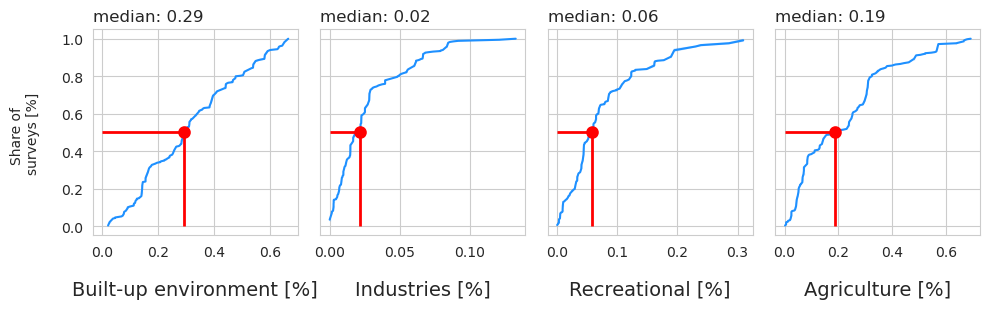

In [16]:
fdx = SurveyResults()
df = fdx.surveyResults()
location_no_luse = ["linth_route9brucke",
                "seez_spennwiesenbrucke",
                'limmat_dietikon_keiserp',
                "seez"]

city_no_luse = ["Walenstadt", "Weesen", "Glarus Nord", "Quarten"]

df = df[~df.location.isin(no_luse_data)]
df = df[~df.city.isin(city_no_luse)]

dfdt = df.groupby(["loc_date", "location"], as_index=False).pcs_m.sum()

def applyBufferDataToSurveys(data, buffer_data):
    
    locations = data.location.unique()
    
    
    for location in locations:
        if location in buffer_data.columns:
            landuse = buffer_data[location]
            data.loc[data.location == location, landuse.index] = landuse.values
        else:
            print(location)
            pass
    return data

daily_totals_landuse = applyBufferDataToSurveys(dfdt, buffer_vals)



pretty_names = {"buildings":"Built-up environment [%]",
                'industrial':'Industries [%]',
                'recreation': 'Recreational [%]',
                'agriculture':'Agriculture [%]',
                'woods':'Forests [%]',               
                'unproductive':'Unproductive land [%]',
                'roads':'Road network \nlength [km]',
                'intersects': 'Rivers/canals [#]',
               }

# method to get the ranked correlation of pcs_m to each explanatory variable
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

sns.set_style("whitegrid")
fig, axs = plt.subplots(1,4, figsize=(10,3.2), sharey=True)

data = daily_totals_landuse
loi = ['buildings', 'industrial','recreation','agriculture','woods','unproductive', 'intersects', 'roads']
for i, n in enumerate(loi[:4]):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y), ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], .5, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=.5, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(pretty_names[n], fontsize=14, labelpad=15)

plt.tight_layout()

plt.show()

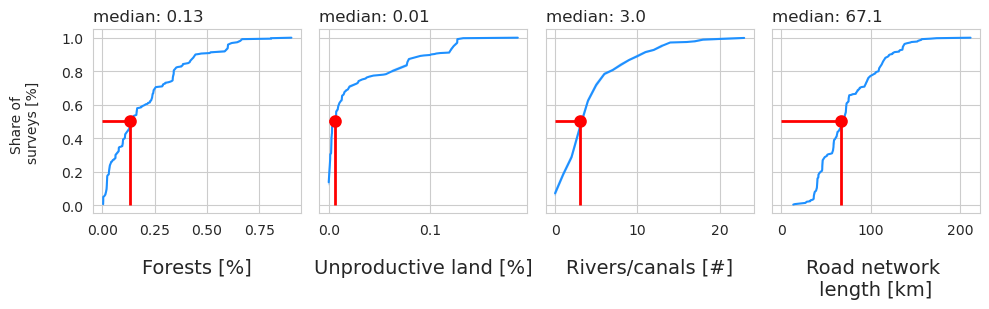

In [17]:
fig, axs = plt.subplots(1,4, figsize=(10,3.2), sharey=True)
for i, n in enumerate(loi[4:]):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y), ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], .5, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=.5, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(pretty_names[n], fontsize=14, labelpad=15)

plt.tight_layout()

plt.show()

### Total correlations, total positive correlations, total negative corrrelations for each buffer radius

In [18]:
def countTheNumberOfCorrelationsPerBuffer(pvals: pdtype = None, rhovals: pdtype = None) -> (pdtype, pstype):
    
    # the number of times p <= 0.05
    number_p_less_than = (pvals <= 0.05).sum()
    number_p_less_than.name = "correlated"
    
    # the number of postive correlations
    number_pos = (rhovals > 0).sum()
    number_pos.name = "positive"
    
    # the number of negative correlations
    number_neg = (rhovals < 0).sum()
    number_neg.name = "negative"

    ncorrelated = pd.DataFrame([number_p_less_than, number_pos, number_neg])
    ncorrelated["total"] = ncorrelated.sum(axis=1)
    totals = ncorrelated.total
    
    
    return ncorrelated, totals

ncorrelated, total = countTheNumberOfCorrelationsPerBuffer(pvals, rhovals)

pairs = [
    (pvals, rhovals, "1.5k"),
    (pvals2k, rhovals2k, "2k"),
    (pvals25k, rhovals25k, "2.5k"),
    (pvals3k, rhovals3k, "3k"),
    (pvals35k, rhovals35k, "3.5k"),
    (pvals4k, rhovals4k, "4k"),
    (pvals45k, rhovals45k, "4.5k"),
    (pvals5k, rhovals5k, "5k"),
    (pvals10k, rhovals10k, "10k")
]

rho_vals_all = [
    rho_at_buffer,
    rho_at_2k,
    rho_at_25k,
    rho_at_3k,
    rho_at_35k,
    rho_at_4k,
    rho_at_45k,
    rho_at_5k,
    rho_at_10k
]

buffers = [
    new_buffer,
    new_buffer_2k,
    new_buffer_2_5k,
    new_buffer_3k,
    new_buffer_3_5k,
    new_buffer_4k,
    new_buffer_4_5k,
    new_buffer_5k,
    new_buffer_10k
]    

rhos_and_ps = []
for pair in pairs:
    _, total = countTheNumberOfCorrelationsPerBuffer(pair[0], pair[1])
    total.name = pair[2]
    rhos_and_ps.append(total)

correlation_results = pd.DataFrame(rhos_and_ps)

res = correlation_results.style.set_table_styles(table_css_styles)
res

,correlated,positive,negative
1.5k,104,51,53
2k,102,52,50
2.5k,101,50,51
3k,94,49,45
3.5k,97,51,46
4k,97,50,47
4.5k,91,50,41
5k,90,48,42
10k,80,52,28


### Changes of land use profile for different buffer zones

As the radius of the buffer zone changes the land use mix changes. Defining the radius of the buffer zone is determined by the scale at which the reporting is being done. For the report to Switzerland the target administrative level was the municipality. Therefore a radius of 1500m was appropriate, given the geographic size of a municipality in Switzerland.

In [19]:
def combineAdjustedBuffers(buffers, pairs):
    
    combined_buffers = []
    for i,n in enumerate(pairs):
        a_buffer=buffers[i].adjusted_buffer
        a_buffer["radius"] = n[2]
        combined_buffers.append(a_buffer[["label", "radius"]])
        
    return pd.concat(combined_buffers, axis=0)
combined_buffers = combineAdjustedBuffers(buffers, pairs)

total_radius = combined_buffers.groupby("radius", as_index=False).label.value_counts()

total_radius = total_radius[total_radius.label != "water"]
total_radius = total_radius.pivot(index="radius", columns="label")
total_radius.columns = total_radius.columns.droplevel()
total_radius = total_radius.div(total_radius.sum(axis=1), axis=0).T
total_radius = total_radius[[total_radius.columns[0], *total_radius.columns[2:], total_radius.columns[1]]]
total_radius = total_radius.mul(100).astype(int)
total_radius.columns.name = None
total_radius.index.name = None
total_radius.style.set_table_styles(table_css_styles)

,1.5k,2.5k,2k,3.5k,3k,4.5k,4k,5k,10k
agriculture,24,26,25,29,28,31,30,32,40
buildings,28,25,26,22,23,19,20,18,8
industrial,3,2,2,2,2,2,2,2,1
recreation,5,4,5,3,4,3,3,2,1
transport,12,10,11,9,10,8,8,8,4
unproductive,2,1,1,1,1,2,1,2,5
woods,24,28,26,30,29,32,31,33,38


__Below:__ Chart of different land use profiles at different buffer radiuses

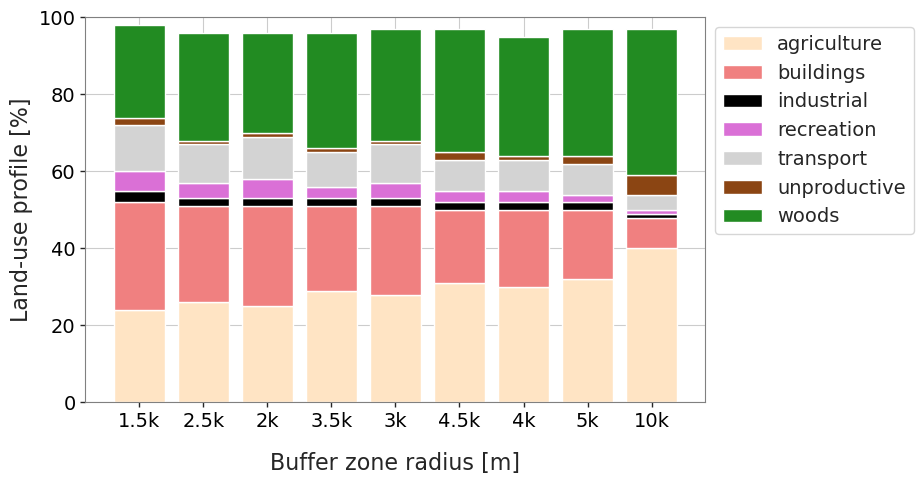

In [20]:
data =total_radius.values
labels = total_radius.index
colors = total_radius.index
xlabels = [str(x) for x in total_radius.columns]

colors = ['bisque','lightcoral','k','orchid','lightgrey','saddlebrown', 'forestgreen']

bottom = [0]*(len(total_radius.columns))

width = 0.8      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(8,5))

for i,group in enumerate(data):
    ax.bar(xlabels, group, width, bottom=bottom, label=labels[i], color = colors[i])
    bottom += group


ax.set_ylabel('Land-use profile [%]', fontsize=16)

ax.set_xlabel("Buffer zone radius [m]", labelpad =15, fontsize=16)
ax.set_facecolor('white')

ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_ylim(0,100)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)

ax.legend(bbox_to_anchor=(1,1), facecolor = 'white', fontsize=14)

plt.show()

### Sum of the total number of objects with a correlation (positive or negative) collected under the different land use categories

In [21]:
def numberOfObjectsCorrelatedPerAttribute(rho_at_buffer: pdtype = None, df: pdtype = None) -> pdtype:
    
    # select all the codes that have a p-value less than 0.05
    p_less_than = rho_at_buffer[rho_at_buffer.exact_p <= 0.05]

    # group the codes by land use attribute
    p_less_than_use_codes = p_less_than.groupby("use").code.unique()

    # sume the number of objects with a correlation (positive or negative) for each land use attribute
    results = nObjectsPerLandUse(p_less_than_use_codes,df)
    
    return results

numberOfObjectsCorrelatedPerAttribute(rho_at_buffer, df)

,total
agriculture,22407
buildings,16004
industrial,6941
intersects,21301
recreation,26231
roads,17108
unproductive,21194
woods,13973


### The % total of materials of the objects of interest with respect to the total number of objects collected.

In [22]:
def thePercentTotalOfMaterials(codes, df, materialmap):
    
    total = df.quantity.sum()
    buffer_codes = df[df.code.isin(codes)].copy()
    buffer_codes["material"] = buffer_codes.code.apply(lambda x: materialmap[x])
    
    material_df = pd.DataFrame(buffer_codes.groupby("material").quantity.sum()/total).round(3)
    
    material_df["quantity"] = material_df.quantity.apply(lambda x: f'{int((x*100))}%')
    
    return material_df

thePercentTotalOfMaterials(codes_fail, df, code_m_map)

,quantity
material,
Cloth,0%
Glass,5%
Metal,2%
Paper,1%
Plastic,75%


### The % total of the objects of interest with respect to all objects collected.

In [23]:
def thePercentTotalOfTheTopXObjects(df, codes):
    index = [f'ratio of the items of interest over all items:',f'number of items of interest:']
    item_totals = df.groupby("code").quantity.sum().sort_values(ascending=False)
    top_x = item_totals.loc[codes].sum()
    total = df.quantity.sum()
    data = [f"{(round((top_x /total)*100))}%","{:,}".format(round(top_x))]
    return pd.DataFrame(data=data, index=index, columns=["value"])

thePercentTotalOfTheTopXObjects(df,codes_fail)

,value
ratio of the items of interest over all items:,84%
number of items of interest:,"39,442"


### The cumulative totals of the objects of interest, grouped by economic source

The object of interest were grouped according to economic source by considering the possible uses for each object, as defined in the object description and sources columns of the default codes data:

1. tobaco: "Tobacco", "Smoking related"
2. industry: 'Industry','Construction', 'Industrial', 'Manufacturing'
3. sanitary: "Sanitary", "Personal hygiene", "Water treatment"
4. packaging: 'Packaging (non-food)','Packaging films nonfood or unknown', 'Paper packaging'
5. food:  'Food and drinks','Foil wrappers, aluminum foil', 'Food and drinks', 'Food and drink'
6. fragments: 'Plastic fragments and pieces', 'Plastic fragments angular <5mm', 'Styrofoam < 5mm', 'Plastic fragments rounded <5mm', 'Foamed  plastic <5mm', 'Fragmented plastics'

In [24]:
def check_condition(x, conditions, i):
    
    if list(set(x)&set(conditions[i])):
        data = conditions[i][0]        
    elif i == 0 and not list(set(x)&set(conditions[i])):
        data = "Others"    
    else:
        data = check_condition(x, conditions, i-1)
    return data

# define the broad categories:
tobaco = ["Tobacco", "Smoking related"]
industry = ['Industry','Construction', 'Industrial', 'Manufacturing']
sanitary = ["Sanitary", "Personal hygiene", "Water treatment"]
packaging = ['Packaging (non-food)','Packaging films nonfood or unknown', 'Paper packaging']
food = ['Food and drinks','Foil wrappers, aluminum foil', 'Food and drinks', 'Food and drink']
fragments = ['Plastic fragments and pieces',
             'Plastic fragments angular <5mm',
             'Styrofoam < 5mm', 
             'Plastic fragments rounded <5mm',
             'Foamed  plastic <5mm',
             'Fragmented plastics',
            ]

conditions = [tobaco, industry, sanitary, packaging, food, fragments]


dT20 = df[df.code.isin(codes_fail)].groupby("code", as_index=False).quantity.sum().sort_values("quantity", ascending=False)
dT20["description"] = dT20.code.map(lambda x: code_d_map[x])
dT20.set_index("code", drop=True, inplace=True)

    
for each_code in dT20.index:
    srcs = dfCodes.loc[each_code][["source", "source_two", "source_three", "description"]]
    a = check_condition(srcs.values, conditions, len(conditions)-1)
    dT20.loc[each_code, "Type"] = a
    
total_type = dT20.groupby(["Type"], as_index=False).quantity.sum()
total_type["Proportion [%]"] = ((total_type.quantity/df.quantity.sum())*100).round(1)
total_type.style.format(precision=1).set_table_styles(table_css_styles)

,Type,quantity,Proportion [%]
0,Food and drinks,7652,16.3
1,Industry,10060,21.5
2,Others,3001,6.4
3,Packaging (non-food),971,2.1
4,Plastic fragments and pieces,6943,14.8
5,Sanitary,2381,5.1
6,Tobacco,8434,18.0


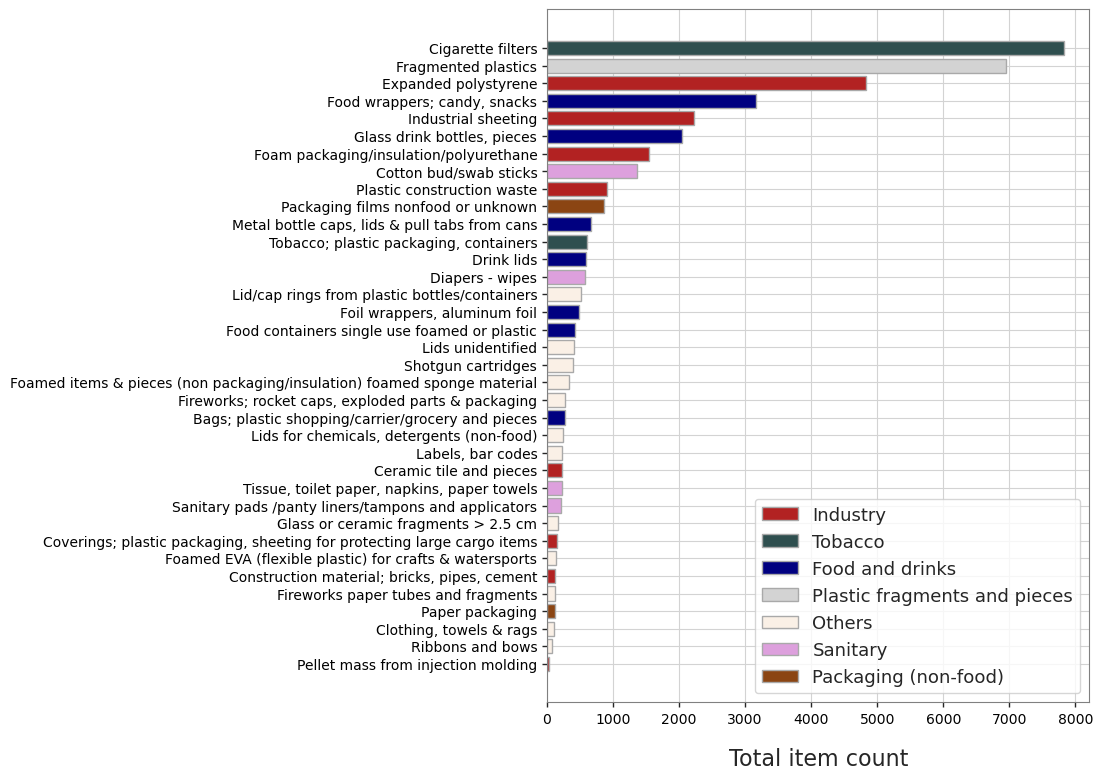

In [25]:
fig, ax = plt.subplots(figsize=(7,9))
colors = {'Industry': 'firebrick', 'Tobacco': 'darkslategrey', 'Food and drinks': 'navy', 'Plastic fragments and pieces':'lightgrey',
         'Others':'linen','Sanitary':'plum','Packaging (non-food)':'saddlebrown'}

width = 0.6

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax.barh(dT20.description, dT20.quantity, color=[colors[i] for i in dT20.Type], edgecolor='darkgrey')
ax.invert_yaxis()  
ax.set_ylabel('')
xticks = [0,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])


ax.set_xlabel('Total item count', fontsize=16, labelpad =15)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=10, width=1)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')
ax.set_facecolor('white')

plt.legend(handles, labels, fontsize=13,facecolor='white', loc="lower right")
for ha in ax.legend_.legend_handles:
    ha.set_edgecolor("darkgrey")

plt.grid(True)
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')

# plt.savefig('C:/Users/schre086/figures/land_use_ch/top_20items.png', bbox_inches='tight')

plt.show()

#### Litter items of local origin

Items that have four or more positive associations with a land use category.

In [26]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
local = correlated.code.value_counts()
local = local[local >= 4]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
code,,
G904,4,279
G177,4,482


#### Ubiquitous items

Items that have three or less positive associations with a land use category and are positively associated with river or stream intersections.

In [27]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
pos_intersects = rho_at_buffer[(rho_at_buffer.use == "intersects") & (rho_at_buffer.exact_p <= 0.05)]
correlated = correlated[correlated.code.isin(pos_intersects.code.unique())]
local = correlated.code.value_counts()
local = local[local <= 3]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
code,,
G98,3,581
G941,3,857
G178,3,668
G25,3,613
G21,2,593
G23,2,405
Gfrags,2,6943
G74,2,1546
G67,1,2221


#### Other items

Items that have three or less positive associations with a land use category and are NOT positively associated with river or stream intersections.

In [28]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
pos_intersects = rho_at_buffer[(rho_at_buffer.use == "intersects") & (rho_at_buffer.exact_p > 0.05)]
correlated = correlated[correlated.code.isin(pos_intersects.code.unique())]
local = correlated.code.value_counts()
local = local[local <= 3]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
code,,
G27,3,7821
G30,3,3159
G923,3,223
G3,2,277
G24,2,509
G200,1,2051
G95,1,1369
G208,1,165
G922,1,233


## Annex
Land-use attributes of the survey locations.

In [29]:
results = buffer_vals.T.round(3)
display_columns = ["buildings",  "industrial", "roads", "recreation", "agriculture","woods", "intersects", "unproductive"]

res = results[display_columns].style.format(precision=3).set_table_styles(table_css_styles)

glue("all_luse", res, display=False)

```{glue:figure} all_luse
---
name: all_luse
---
` `
```
{numref}`figure %s: <all_luse>` The land use attributes of the survey locations @ 1 500 m radius

In [30]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

_ANALYSTATHAMMERDIRT_
"""

md(my_block)



This script updated 08/05/2023 in Biel, CH

> ❤️ what you do everyday

_ANALYSTATHAMMERDIRT_


In [31]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/landuse.git

Git branch: probability

pandas    : 2.0.0
seaborn   : 0.12.2
matplotlib: 3.7.1
scipy     : 1.10.1
numpy     : 1.24.2
PIL       : 9.5.0
json      : 2.0.9
IPython   : 8.12.0

